In [13]:
# Data processing
# ==============================================================================
import os
import pandas as pd
import numpy as np

# Plotting
# ==============================================================================
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
import plotly.offline as poff
pio.templates.default = "seaborn"
poff.init_notebook_mode(connected=True)

# Time series modeling
# ==============================================================================
import skforecast
from skforecast.model_selection import TimeSeriesFold,  OneStepAheadFold
from skforecast.model_selection import backtesting_forecaster_multiseries
from sklearn.feature_selection import RFECV

import sklearn
from sklearn.feature_selection import RFECV
from skforecast.recursive import ForecasterEquivalentDate
from skforecast.recursive import ForecasterRecursive
from skforecast.model_selection import bayesian_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.model_selection import TimeSeriesFold

from skforecast.preprocessing import RollingFeatures
from sklearn.ensemble import RandomForestRegressor

#make column datetime to index
pio.templates.default = "seaborn"
poff.init_notebook_mode(connected=True)
plt.style.use('seaborn-v0_8-darkgrid')

plt.style.use('fivethirtyeight')

In [48]:
df1 = pd.read_excel('C:/Users/Christian/Documents/Cand_merc/Data-Science-Project/data_science_project/Praktik/data_final.xlsx')

In [49]:
df = df1.copy()
#drop missing data
df = df.dropna()

In [5]:
df = df.set_index('datetime')

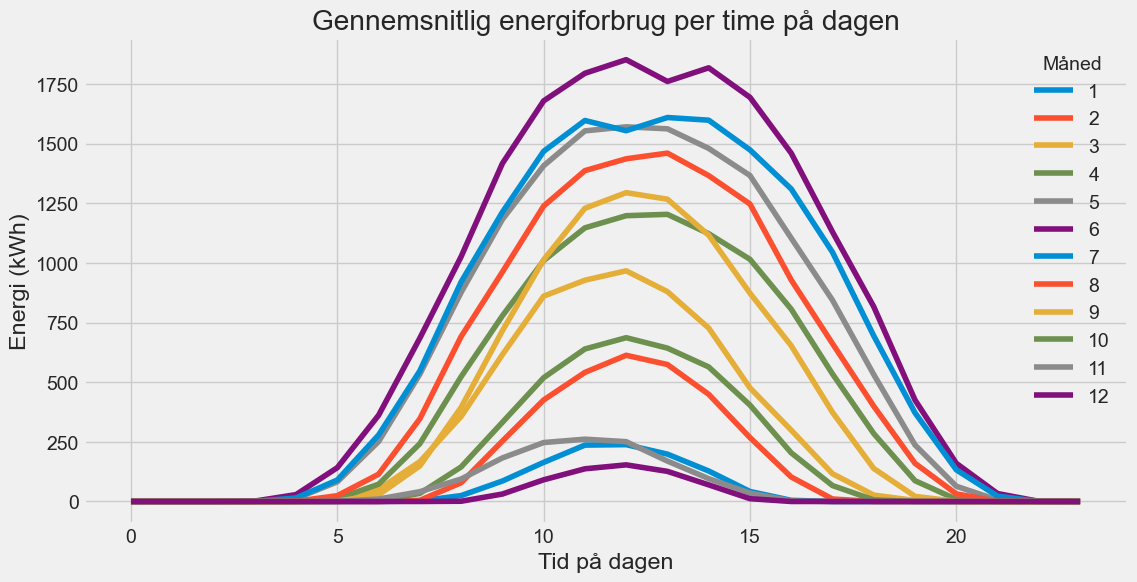

In [ ]:
# Group by month and hour, then calculate the mean of energy_total
df['month'] = df.index.month
df['hour'] = df.index.hour

# Pivot the table to have hours as index and months as columns
pivot_table = df.pivot_table(values='energy_total', index='hour', columns='month', aggfunc='mean')

# Plot the pivot table
pivot_table.plot(kind='line', figsize=(12, 6))
plt.ylabel('Energi (kWh)')
plt.title('Gennemsnitlig energiforbrug per time på dagen')
plt.xlabel('Tid på dagen')
plt.legend(title='Måned')
plt.show()

In [11]:
#what is the highest energy consumption
df['energy_total'].idxmax()
#what is the lowest energy consumption
df['energy_total'].idxmin()

#print the highest and lowest energy consumption
print('Highest energy consumption:', df['energy_total'].max())
print('Lowest energy consumption:', df['energy_total'].min())

Highest energy consumption: 2723.56
Lowest energy consumption: 0.0


In [50]:
# Initially include all rows
df["Include"] = True

# Function to tag rows based on conditions
def tag_abnormal_values(df, condition, include_col='Include'):
    """
    Updates the Include column to False for rows that satisfy the given condition.

    :param df: The DataFrame to modify.
    :param condition: A condition (boolean array or series) for abnormal values.
    :param include_col: The column name to update for inclusion.
    :return: Modified DataFrame with updated Include column.
    """
    df.loc[condition, include_col] = False
    return df

# Define conditions for abnormality
conditions = [
    (df['energy_total'] < 1) | (df['energy_total'] > 2800)
]

# Exclude abnormal features
for condition in conditions:
    df = tag_abnormal_values(df, condition)
# Cut out all abnormal values
df = df[df.Include].drop(["Include"], axis=1)

#delete columns 'dhi', 'dni', 'precip', 'snow', 'wind_spd'
df = df.drop(['dhi', 'dni', 'precip', 'snow', 'wind_spd'], axis=1)

#extract the hour from the datetime column
df['hour'] = pd.DatetimeIndex(df['datetime']).hour

#only keep rows where hour is between 8 and 18
df = df[(df['hour'] >= 8) & (df['hour'] <= 18)]
#delete three first rows
df = df.iloc[3:]

#drop hour column
df = df.drop(['hour'], axis=1)
df = df.drop(['hour_nr'], axis=1)
df = df.drop(['day_of_year'], axis=1)
df = df.drop(['month_nr'], axis=1)

#start the data from date 2022-03-30 08:00:00
df = df[df['datetime'] >= '2022-03-30 08:00:00']

#delete energy_total in df
#df = df.drop(columns=['datetime'], axis=1)

In [51]:
columns_to_lag = ['clouds', 'ghi', 'pres', 'solar_rad', 'temp', 'uv']
# Define lags to create
lags = [10, 20, 30]

# Create lagged features
for lag in lags:
    for col in df[columns_to_lag]:
        df[f'{col}_lag_{lag}'] = df[col].shift(lag)

# Drop rows with NaN values caused by lagging
df = df.dropna()

print(df)

                 datetime  clouds  ghi  pres   slp  solar_rad  temp   uv  \
195   2022-04-02 12:00:00     100  628  1017  1020        168   3.3  2.1   
196   2022-04-02 13:00:00     100  579  1017  1020        160   4.1  1.7   
197   2022-04-02 14:00:00      81  490  1017  1020        275   4.9  1.2   
198   2022-04-02 15:00:00      55  370  1016  1019        326   4.2  1.0   
199   2022-04-02 16:00:00      29  231  1016  1019        228   5.5  0.8   
...                   ...     ...  ...   ...   ...        ...   ...  ...   
23475 2024-11-30 09:00:00      59   93  1024  1026         79   1.7  1.1   
23476 2024-11-30 10:00:00      78  148  1024  1026         91   2.4  0.9   
23477 2024-11-30 11:00:00      85  171  1024  1026         82   2.8  0.8   
23478 2024-11-30 12:00:00     100  159  1023  1025         75   3.2  0.6   
23479 2024-11-30 13:00:00      70  113  1023  1025         83   3.7  0.9   

       energy_total  month_sin  ...  pres_lag_20  solar_rad_lag_20  \
195          802.

In [52]:
df.reset_index(drop=True, inplace=True)  # Use RangeIndex

train_end = int(0.80 * len(df))
val_end = train_end + int(0.10 * len(df))

df_train = df.iloc[:train_end, :].copy()
df_val = df.iloc[train_end:val_end, :].copy()
df_test = df.iloc[val_end:, :].copy()

print(f"Train size: {len(df_train)}")
print(f"Validation size: {len(df_val)}")
print(f"Test size: {len(df_test)}")

Train size: 6560
Validation size: 820
Test size: 821


In [53]:
# Calculate mean and standard deviation for all features except 'energy_total'
features_to_scale = ['clouds', 'ghi', 'pres', 'slp', 'solar_rad', 'temp', 'uv',
       'clouds_lag_10', 'ghi_lag_10',
       'pres_lag_10', 'solar_rad_lag_10', 'temp_lag_10', 'uv_lag_10',
       'clouds_lag_20', 'ghi_lag_20', 'pres_lag_20', 'solar_rad_lag_20',
       'temp_lag_20', 'uv_lag_20', 'clouds_lag_30', 'ghi_lag_30',
       'pres_lag_30', 'solar_rad_lag_30', 'temp_lag_30', 'uv_lag_30']

train_mean = df_train[features_to_scale].mean()
train_std = df_train[features_to_scale].std()

# Scale the selected features
df_train[features_to_scale] = (df_train[features_to_scale] - train_mean) / train_std
df_val[features_to_scale] = (df_val[features_to_scale] - train_mean) / train_std
df_test[features_to_scale] = (df_test[features_to_scale] - train_mean) / train_std
df[features_to_scale] = (df[features_to_scale] - train_mean) / train_std

In [54]:
#define that exog_features are all columns except energy_total and datetime
exog_features = [col for col in df.columns if col not in ['energy_total', 'datetime']]

In [55]:
df.columns

Index(['datetime', 'clouds', 'ghi', 'pres', 'slp', 'solar_rad', 'temp', 'uv',
       'energy_total', 'month_sin', 'month_cos', 'day_sin', 'day_cos',
       'hour_sin', 'hour_cos', 'sine_elevation', 'cosine_elevation',
       'sine_azimuth', 'cosine_azimuth', 'clouds_lag_10', 'ghi_lag_10',
       'pres_lag_10', 'solar_rad_lag_10', 'temp_lag_10', 'uv_lag_10',
       'clouds_lag_20', 'ghi_lag_20', 'pres_lag_20', 'solar_rad_lag_20',
       'temp_lag_20', 'uv_lag_20', 'clouds_lag_30', 'ghi_lag_30',
       'pres_lag_30', 'solar_rad_lag_30', 'temp_lag_30', 'uv_lag_30'],
      dtype='object')

In [56]:
from skforecast.preprocessing import RollingFeatures
from xgboost import XGBRegressor
# Create forecaster
# ==============================================================================
forecaster_xgb = ForecasterRecursive(
                regressor       = XGBRegressor(random_state=15926, enable_categorical=True, tree_method='hist'),
                lags            = 10
             )

# Folds used for the hyperparameter search and backtesting
# ==============================================================================
cv_search = OneStepAheadFold(initial_train_size = len(df_train))

cv_backtesting = TimeSeriesFold(
                    steps              = 10,
                    initial_train_size = len(df[:val_end]),
                    refit              = True
                 )

# Lags used as predictors
lags_grid = [[1, 2, 3,10]]


# Enhanced Regressor hyperparameters search space
def search_space(trial):
    search_space = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 2000, step=100),
        'max_depth': trial.suggest_int('max_depth', 2, 16, step=1),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.5, step=0.001),
        'subsample': trial.suggest_float('subsample', 0.5, 1, step=0.05),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1, step=0.05),
        'gamma': trial.suggest_float('gamma', 0, 10, step=0.1),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 10, step=0.1),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 10, step=0.1),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10, step=1),
        'lags': trial.suggest_categorical('lags', lags_grid),
    }
    return search_space

# Perform the Bayesian search
results_search, frozen_trial = bayesian_search_forecaster(
    forecaster=forecaster_xgb,
    y=df.loc[:val_end, 'energy_total'],
    exog=df.loc[:val_end, exog_features],
    cv=cv_search,
    search_space=search_space,
    metric='mean_absolute_error',
    n_trials=100,  # Increased number of trials for more exhaustive search
    random_state=123,
    return_best=True,
    n_jobs='auto',
    verbose=True,  # Set to True to monitor progress
    show_progress=True
)

best_params = results_search['params'].iloc[0]

c:\Users\Christian\AppData\Local\Programs\Python\Python311\Lib\site-packages\skforecast\model_selection\_search.py:715: OneStepAheadValidationWarning:

One-step-ahead predictions are used for faster model comparison, but they may not fully represent multi-step prediction performance. It is recommended to backtest the final model for a more accurate multi-step performance estimate. 
 You can suppress this warning using: warnings.simplefilter('ignore', category=OneStepAheadValidationWarning)



  0%|          | 0/100 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3 10] 
  Parameters: {'n_estimators': 1700, 'max_depth': 4, 'learning_rate': 0.018000000000000002, 'subsample': 0.55, 'colsample_bytree': 0.75, 'gamma': 4.800000000000001, 'reg_alpha': 1.5, 'reg_lambda': 3.6, 'min_child_weight': 1}
  One-step-ahead metric: 272.11812108512623


In [57]:
# Backtesting model with exogenous variables on test data
# ==============================================================================
metric_xgboost, predictions_xgb = backtesting_forecaster(
    forecaster    = forecaster_xgb,
    y             = df['energy_total'],
    exog          = df[exog_features],
    cv            = cv_backtesting,
    metric        = 'mean_absolute_error',
    interval      = [7.5, 92.5],
    n_boot        = 250,
    use_in_sample_residuals= True,
    use_binned_residuals=False,
    n_jobs        = 'auto',
    verbose       = False,
    show_progress=True
)
metric_xgboost
display(metric_xgboost)
predictions_xgb.head(5)

c:\Users\Christian\AppData\Local\Programs\Python\Python311\Lib\site-packages\skforecast\model_selection\_validation.py:185: LongTrainingWarning:

The forecaster will be fit 83 times. This can take substantial amounts of time. If not feasible, try with `refit = False`.
 
 You can suppress this warning using: warnings.simplefilter('ignore', category=LongTrainingWarning)



  0%|          | 0/83 [00:00<?, ?it/s]

,mean_absolute_error
0,219.571308


,pred,lower_bound,upper_bound
7380,1725.780762,1465.196719,1914.324942
7381,1575.503540,1367.797684,1826.352734
7382,1349.906372,1183.596402,1655.178543
7383,1309.935669,1076.044870,1542.834131
7384,1116.715820,864.075105,1310.783261


In [42]:
pio.templates.default = "seaborn"
poff.init_notebook_mode(connected=True)
plt.style.use('seaborn-v0_8-darkgrid')

plt.style.use('fivethirtyeight')

# Function to plot predicted intervals
# ======================================================================================
def plot_predicted_intervals(
    predictions: pd.DataFrame,
    y_true: pd.DataFrame,
    target_variable: str,
    initial_x_zoom: list=None,
    title: str=None,
    xaxis_title: str=None,
    yaxis_title: str=None,
):
    """
    Plot predicted intervals vs real values

    Parameters
    ----------
    predictions : pandas DataFrame
        Predicted values and intervals.
    y_true : pandas DataFrame
        Real values of target variable.
    target_variable : str
        Name of target variable.
    initial_x_zoom : list, default `None`
        Initial zoom of x-axis, by default None.
    title : str, default `None`
        Title of the plot, by default None.
    xaxis_title : str, default `None`
        Title of x-axis, by default None.
    yaxis_title : str, default `None`
        Title of y-axis, by default None.
    
    """

    pio.templates.default = "seaborn"
    poff.init_notebook_mode(connected=True)
    plt.style.use('seaborn-v0_8-darkgrid')

    plt.style.use('fivethirtyeight')
    fig = go.Figure([
        go.Scatter(name='Forecast', x=predictions.index, y=predictions['pred'], mode='lines'),
        go.Scatter(name='Aktuelle værdi', x=y_true.index, y=y_true[target_variable], mode='lines'),
        go.Scatter(
            name='Øvre grønde', x=predictions.index, y=predictions['upper_bound'],
            mode='lines', marker=dict(color="#444"), line=dict(width=0), showlegend=False
        ),
        go.Scatter(
            name='Nedre grænde', x=predictions.index, y=predictions['lower_bound'],
            marker=dict(color="#444"), line=dict(width=0), mode='lines',
            fillcolor='rgba(68, 68, 68, 0.3)', fill='tonexty', showlegend=False
        )
    ])
    fig.update_layout(
        title=title,
        xaxis_title=xaxis_title,
        yaxis_title=yaxis_title,
        width=1000,
        height=600,
        margin=dict(l=20, r=20, t=35, b=20),
        hovermode="x",
        xaxis=dict(range=initial_x_zoom),
        legend=dict(orientation="h", yanchor="top", y=1.1, xanchor="left", x=0.001)
    )

    fig.show()


def empirical_coverage(y, lower_bound, upper_bound):
    """
    Calculate coverage of a given interval
    """
    return np.mean(np.logical_and(y >= lower_bound, y <= upper_bound))

In [43]:
#make column datetime to index
pio.templates.default = "seaborn"
poff.init_notebook_mode(connected=True)
plt.style.use('seaborn-v0_8-darkgrid')

plt.style.use('fivethirtyeight')
# Plot intervals (with zoom ['2012-12-01', '2012-12-20'])
# ==============================================================================
plot_predicted_intervals(
    predictions     = predictions_xgb,
    y_true          = df_test,
    target_variable = "energy_total",
    initial_x_zoom  = ['8883', '8993'],
    title           = "Observerede værdier vs. forudsigede intervaller",
    xaxis_title     = "Tid",
    yaxis_title     = "Energi (kWh)",
)

# Predicted interval coverage (on test data)
# ==============================================================================
coverage = empirical_coverage(
                y           = df.loc[val_end:, 'energy_total'],
                lower_bound = predictions_xgb["lower_bound"], 
                upper_bound = predictions_xgb["upper_bound"]
            )
print(f"Predicted interval coverage: {round(100 * coverage, 2)} %")

# Area of the interval
# ==============================================================================
area = (predictions_xgb["upper_bound"] - predictions_xgb["lower_bound"]).sum()
print(f"Område for interval: {round(area, 2)}")

Predicted interval coverage: 80.29 %
Område for interval: 596431.37


In [44]:
df_results = pd.DataFrame({
    'datetime': df_test['datetime'],
    'actual': df_test['energy_total'],
    'predictions': predictions_xgb['pred'],
    'lower_bound': predictions_xgb['lower_bound'],
    'upper_bound': predictions_xgb['upper_bound']
})

print(df_results.head())

                datetime   actual  predictions  lower_bound  upper_bound
8759 2024-08-16 15:00:00  1248.84  1391.844849  1156.238525  1624.411221
8760 2024-08-16 16:00:00   801.32  1127.014404   868.876733  1433.447443
8761 2024-08-16 17:00:00   635.96   750.990540   539.114180  1089.478751
8762 2024-08-16 18:00:00   362.68   457.151947   175.565936   743.295540
8763 2024-08-17 08:00:00  1096.00   711.233276   358.768895  1029.468939


In [47]:
#save the results to an excel file
df_results.to_excel('C:/Users/Christian/Documents/Cand_merc/Data-Science-Project/data_science_project/Praktik/results.xlsx')

In [58]:
cv = TimeSeriesFold(
                    steps              = 10,
                    initial_train_size = len(df[:train_end]),
                    refit              = False
                 )

_, predictions_val = backtesting_forecaster(
                         forecaster    = forecaster_xgb,
                         y             = df.loc[:val_end, 'energy_total'],
                         exog          = df.loc[:val_end, exog_features],
                         cv            = cv,
                         metric        = 'mean_absolute_error',
                         n_jobs        = 'auto',
                         verbose       = False,
                         show_progress = True
                     )

  0%|          | 0/98 [00:00<?, ?it/s]

positive    496
negative    478
Name: count, dtype: int64


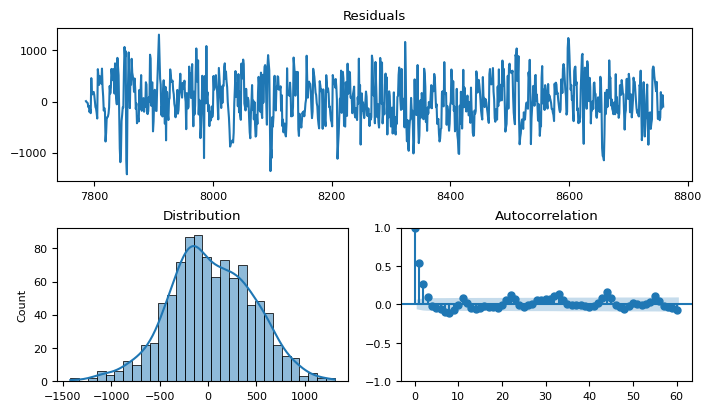

In [51]:
from skforecast.plot import plot_residuals
from skforecast.plot import plot_prediction_distribution
# Out-sample residuals distribution
# ==============================================================================
residuals = df.loc[predictions_val.index, 'energy_total'] - predictions_val['pred']
print(pd.Series(np.where(residuals < 0, 'negative', 'positive')).value_counts())
plt.rcParams.update({'font.size': 8})
_ = plot_residuals(residuals=residuals, figsize=(7, 4))